In [1]:
import sys
sys.path.append('../src/')
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus import Corpus
from models import GTM
from simulations import generate_documents
from joblib import Parallel, delayed
import numpy as np

num_docs = 20000
num_topics = 6
vocab_size = 500
min_words = 100
max_words = 100
num_covs = 0
doc_topic_prior = 'logistic_normal'

# ----- Simulate data -----

df_true_dist_list_gtm, df, topic_word_matrices, lambda_, label_coeffs = generate_documents(
    num_docs,
    num_topics,
    vocab_size,
    doc_topic_prior='logistic_normal',
    min_words=min_words,
    max_words=min_words,
    random_seed=42
)  

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  
vectorizer.fit(df["doc_clean_0"])

modalities = {
    "text": {
        "column": "doc_clean_0",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer
            }
        }
    }
}

full_dataset = Corpus(
    df,
    modalities=modalities
)

In [3]:
# ----- Corpus + GTM -----

encoder_args = {
    "text_bow": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

decoder_args = {
    "text_bow": {
        "hidden_dims": [64,128],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

tm = GTM(
    train_data=full_dataset,
    n_topics=num_topics,
    ae_type="vae",
    update_prior=False,
    doc_topic_prior=doc_topic_prior,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    print_every_n_epochs=10,
    print_every_n_batches=1000,
    log_every_n_epochs=1,
    w_prior=1,
    patience=10,
    batch_size=64,
    num_epochs=100,
    seed=42,
    kl_annealing_start=0,
    kl_annealing_end=1000,
    kl_annealing_max_beta=1
)


Epoch  10	Mean Training Loss:5.4418094


Stopping at Epoch 17. Reverting to Epoch 7


In [4]:
# ----- Evaluate alignment of topics -----

df_doc_topic_gtm = pd.DataFrame(
    tm.get_doc_topic_distribution(full_dataset, num_samples=30),
    index=[f"Doc{i}" for i in range(num_docs)],
    columns=[f"Topic{i}" for i in range(num_topics)]
)

true_df = df_true_dist_list_gtm

# Match estimated to true topics using dot-product alignment
score_matrix = pd.DataFrame([
    [np.dot(true_df[f"Topic{t}"], df_doc_topic_gtm[f"Topic{e}"]) for e in range(num_topics)]
    for t in range(num_topics)
])

true_topics, estimated_topics = linear_sum_assignment(-score_matrix.values)

corres_num_topic_dict_gtm = {
    f"Topic{t}": f"Topic{e}" for t, e in zip(true_topics, estimated_topics)
}
corres_num_topic_dict_gtm_bis = {
    t: e for t, e in zip(true_topics, estimated_topics)
}

reanged_df_gtm = df_doc_topic_gtm.loc[:, corres_num_topic_dict_gtm.values()]
reanged_df_gtm.columns = corres_num_topic_dict_gtm.keys()

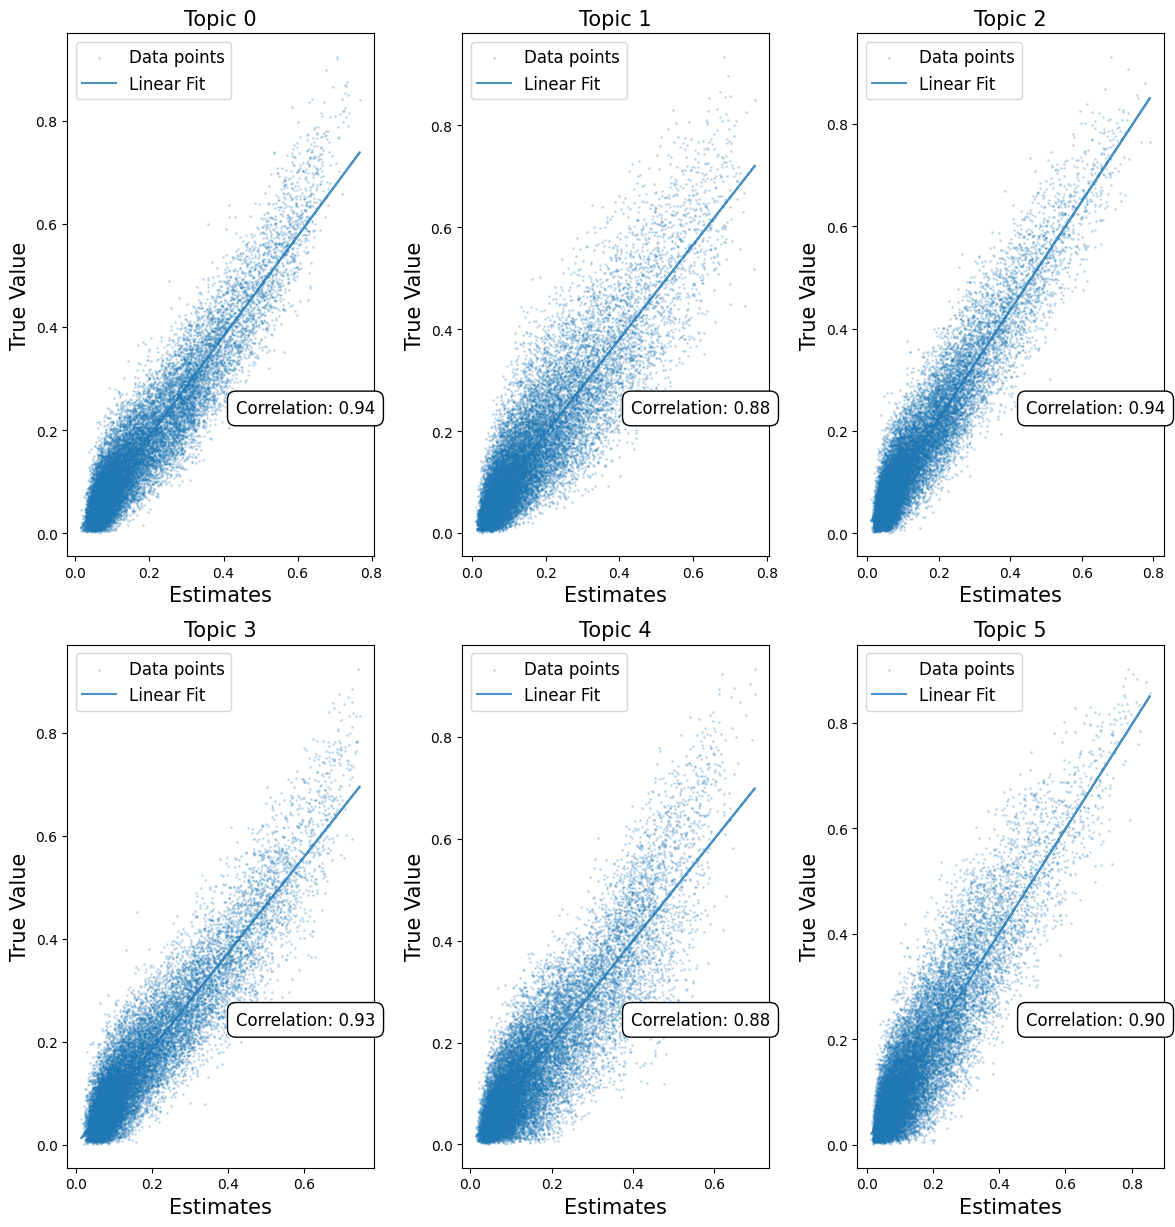

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of topics
num_topics = len(reanged_df_gtm.columns)  # Assuming each column corresponds to a topic

# Define grid dimensions: 2 figures per row
n_cols = 3
n_rows = (num_topics + 1) // 2  # This ensures you have enough rows to accommodate all topics

# Create subplots with the grid layout
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows)) 

# Flatten the axs array to handle it as a 1D list
axs = axs.flatten()

for i in range(num_topics):  
    x = reanged_df_gtm['Topic{}'.format(i)]
    y = true_df['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, label='Data points', s=1, alpha=0.2)
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), label='Linear Fit', alpha=0.8)
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title('Topic {}'.format(i), fontsize=15)
    axs[i].legend(fontsize=12)

    # Calculate correlation coefficient
    corr_coeff = np.corrcoef(x, y)[0, 1]
    # Add annotation
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                 fontsize=12, verticalalignment='top', horizontalalignment='left',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Hide any unused subplots if num_topics is odd
for j in range(num_topics, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout() 
plt.show()